In [1]:
import numpy as np
import os
import tensorflow.compat.v1 as tf
import magenta.music as mm
from magenta.music.sequences_lib import concatenate_sequences
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
#from google.colab import files

tf.disable_v2_behavior()

c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import json
input_file = open('saveZ.json')
latent_vectors = json.load(input_file)
keys = list(latent_vectors.keys())

In [3]:
# Parameters
BATCH_SIZE = 4
Z_SIZE = 512
TOTAL_STEPS = 512
BAR_SECONDS = 2.0
CHORD_DEPTH = 49

SAMPLE_RATE = 44100
SF2_PATH = '/content/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

In [4]:
# Functions

# Chord encoding tensor.
def chord_encoding(chord):
  index = mm.TriadChordOneHotEncoding().encode_event(chord)
  c = np.zeros([TOTAL_STEPS, CHORD_DEPTH])
  c[0,0] = 1.0
  c[1:,index] = 1.0
  return c

# Trim sequences to exactly one bar.
def trim_sequences(seqs, num_seconds=BAR_SECONDS):
  for i in range(len(seqs)):
    seqs[i] = mm.extract_subsequence(seqs[i], 0.0, num_seconds)
    seqs[i].total_time = num_seconds

# Consolidate instrument numbers by MIDI program.
def fix_instruments_for_concatenation(note_sequences):
  instruments = {}
  for i in range(len(note_sequences)):
    for note in note_sequences[i].notes:
      if not note.is_drum:
        if note.program not in instruments:
          if len(instruments) >= 8:
            instruments[note.program] = len(instruments) + 2
          else:
            instruments[note.program] = len(instruments) + 1
        note.instrument = instruments[note.program]
      else:
        note.instrument = 9

# Spherical linear interpolation.
def slerp(p0, p1, t):
  """Spherical linear interpolation."""
  omega = np.arccos(np.dot(np.squeeze(p0/np.linalg.norm(p0)), np.squeeze(p1/np.linalg.norm(p1))))
  so = np.sin(omega)
  return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

In [5]:
config = configs.CONFIG_MAP['hier-multiperf_vel_1bar_med_chords']
model = TrainedModel(
    config, 
    batch_size=BATCH_SIZE,
    checkpoint_dir_or_path='content/model_chords_fb64.ckpt')

INFO:tensorflow:Building MusicVAE model with HierarchicalLstmEncoder, HierarchicalLstmDecoder, and hparams:
{'max_seq_len': 512, 'z_size': 512, 'free_bits': 0.0, 'max_beta': 1.0, 'beta_rate': 0.0, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [512, 512, 512], 'enc_rnn_size': [1024], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'constant', 'sampling_rate': 0.0, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Hierarchical Encoder:
  input length: 512
  level lengths: [64, 8]

INFO:tensorflow:Level 0 splits: 8
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [1024]

INFO:tensorflow:Level 1 splits: 1
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [1024]



INFO:tensorflow:
Hierarchical Decoder:
  input length: 512
  level output lengths: [8, 64]

INFO:tensorflow:
Decoder Cells:
  units: [512, 512, 512]



c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\magenta\models\music_vae\lstm_utils.py:99: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  name=name),
c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\magenta\contrib\rnn.py:750: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  self._names["W"], [input_size + self._num_units, self._num_units * 4])
c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\magenta\contrib\rnn.py:753: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  initializer=tf.constant_initializer(0.0))


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\magenta\models\music_vae\base_model.py:199: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))
c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\magenta\models\music_vae\base_model.py:205: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))


INFO:tensorflow:Restoring parameters from content/model_chords_fb64.ckpt


In [26]:
z1 = np.expand_dims(latent_vectors.get(keys[0]), 0)
z2 = np.expand_dims(latent_vectors.get(keys[1]), 0)
z = np.array([slerp(z1, z2, t)
              for t in np.linspace(0, 1, 10)])
z = np.squeeze(z, 1)
print(z.shape)

(10, 512)


In [39]:
chord_1 = 'Dm' #@param {type:"string"}
chord_2 = 'F' #@param {type:"string"}
chord_3 = 'Am' #@param {type:"string"}
chord_4 = 'G' #@param {type:"string"}
chords = [chord_1, chord_2, chord_3, chord_4]

num_bars = 10 #@param {type:"slider", min:4, max:64, step:4}
temperature = 0.2 #@param {type:"slider", min:0.01, max:1.5, step:0.01}

z1 = np.random.normal(size=[Z_SIZE])
z2 = np.random.normal(size=[Z_SIZE])
z = np.array([slerp(z1, z2, t)
              for t in np.linspace(0, 1, num_bars)])

seqs = [
    model.decode(length=TOTAL_STEPS, z=z[i:i+1, :], temperature=temperature,
                 c_input=chord_encoding(chords[i % 4]))[0]
    for i in range(num_bars)
]

trim_sequences(seqs)
fix_instruments_for_concatenation(seqs)
prog_interp_ns = concatenate_sequences(seqs)

mm.plot_sequence(prog_interp_ns)

Loading BokehJS ...

In [36]:
z1 = np.expand_dims(latent_vectors.get(keys[0]), 0)
z2 = np.expand_dims(latent_vectors.get(keys[1]), 0)
z = np.array([slerp(z1, z2, t)
              for t in np.linspace(0, 1, 4)])
z = np.squeeze(z, 1)

seqs = model.decode(length=TOTAL_STEPS, z=z, temperature=0.2, c_input=chord_encoding('C'))

trim_sequences(seqs)
fix_instruments_for_concatenation(seqs)
interp_ns = concatenate_sequences(seqs)

mm.plot_sequence(interp_ns)

Loading BokehJS ...

In [9]:
z1 = np.expand_dims(latent_vectors.get(keys[2]), 0)
chord_1 = 'Dm' #@param {type:"string"}
chord_2 = 'F' #@param {type:"string"}
chord_3 = 'Am' #@param {type:"string"}
chord_4 = 'G' #@param {type:"string"}
chords = [chord_1, chord_2, chord_3, chord_4]

seqs = [
    model.decode(length=TOTAL_STEPS, z=z1, temperature=0.01, c_input=chord_encoding(c))[0]
    for c in chords
  ]


trim_sequences(seqs)
fix_instruments_for_concatenation(seqs)
interp_ns = concatenate_sequences(seqs)

mm.plot_sequence(interp_ns)

Loading BokehJS ...

In [8]:
z = latent_vectors.get(keys[0])
z = np.expand_dims(z,0)
z.shape


(1, 512)

In [22]:
for i in range(9):
    chord_1 = 'C'
    chords = [chord_1]

    # fix the temperature to the minimum value
    temperature = 0.01 #@param {type:"slider", min:0.01, max:1.5, step:0.01}
    #z = np.random.normal(size=[1, Z_SIZE])
    z = latent_vectors.get(keys[i])
    z = np.expand_dims(z,0)
    seqs = [
        model.decode(length=TOTAL_STEPS, z=z, temperature=temperature,
                c_input=chord_encoding(c))[0]
        for c in chords
    ]

    #double_seq = seqs + seqs
    #trim_sequences(double_seq)

    fix_instruments_for_concatenation(seqs)
    prog_ns = concatenate_sequences(seqs)

[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]
[qpm: 120.0
]


## test 2

In [32]:
from collections import Counter
iter = 100
harmonic = []

for i in range(iter):

    #double_seq = []
    chord_1 = 'C'
    chords = [chord_1]

    # fix the temperature to the minimum value
    temperature = 0.01 #@param {type:"slider", min:0.01, max:1.5, step:0.01}
    z = np.random.normal(size=[1, Z_SIZE])

    seqs = [
        model.decode(length=TOTAL_STEPS, z=z, temperature=temperature,
                    c_input=chord_encoding(c))[0]
        for c in chords
    ]

    #double_seq = seqs + seqs
    #trim_sequences(double_seq)
    fix_instruments_for_concatenation(seqs)
    prog_ns = concatenate_sequences(seqs)

    #harmonic = []

    for notes in prog_ns.notes:
        if notes.instrument == 9:
            harmonic.append(notes.program)

    #num_inst = set(harmonic)
    dict = Counter(harmonic)
    sort = list(dict.keys())
    sort.sort()
    sort_dict = {i:dict[i] for i in sort}
    print(sort_dict)

    #print("iterazione numero {}/{}".format(i+1,iter))
    #print("numero di note {}".format(num_inst))



{0: 12}
{0: 27}
{0: 35}
{0: 43}
{0: 51}
{0: 59}
{0: 67}
{0: 76}
{0: 88}
{0: 88}
{0: 96}


KeyboardInterrupt: 

## test


In [93]:
print(f"su un campione di {iter} sequenze...")
print( " il numero di sequenze con meno di 4 note è: {}" .format(len(list_latent_few_inst)))
print( " il numero di sequenze con piu di 12 note è: {}" .format(len(list_latent_lot_inst)))

su un campione di 250 sequenze...
 il numero di sequenze con meno di 4 note è: 26
 il numero di sequenze con piu di 12 note è: 9


In [7]:
import json

 # ------ CHECK ----------
with open('latent_few_inst.json', 'w') as f:
    json.dump(np.ndarray.tolist(list_latent_few_inst[0])[0], f)

with open('latent_lot_inst.json', 'w') as f:
    json.dump(np.ndarray.tolist(list_latent_lot_inst[0])[0], f)

with open('all_latent.json', 'w') as f:
    json.dump(np.ndarray.tolist(all_latent[0])[0], f)

In [8]:
input_file = open ('latent_few_inst.json')
latent_few_inst_list = json.load(input_file)

input_file = open ('latent_lot_inst.json')
latent_lot_inst_list = json.load(input_file)

In [94]:
array_few_inst = np.zeros((len(list_latent_few_inst), 512))
for i in range(len(list_latent_few_inst)):
    array_few_inst[i] = list_latent_few_inst[i]

array_lot_inst = np.zeros((len(list_latent_lot_inst), 512))
for i in range(len(list_latent_lot_inst)):
    array_lot_inst[i] = list_latent_lot_inst[i]

array_tot_inst = np.concatenate((array_few_inst, array_lot_inst), axis=0)

In [95]:
from sklearn.manifold import TSNE

latent_emb = TSNE(n_components=2, perplexity=3).fit_transform(array_tot_inst)

c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\rikyd\Documents\GitHub\CPAC_Group_7\magenta-env\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


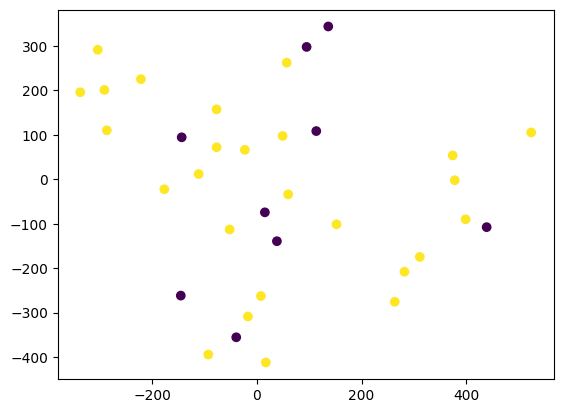

In [96]:
import matplotlib.pyplot as plt

c1 = np.ones(len(list_latent_few_inst))*255
c2 = np.ones(len(list_latent_lot_inst))
c = np.concatenate((c1,c2))

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(latent_emb[:,0], latent_emb[:,1], c=c)


In [102]:
mean_array_few_inst = np.mean(array_few_inst, axis=0)
mean_array_lot_inst = np.mean(array_lot_inst, axis=0)
attribute_harmonic = mean_array_lot_inst - mean_array_few_inst

In [105]:
for i in range(11):
    #double_seq = []
    chord_1 = 'C'
    chords = [chord_1]

    # fix the temperature to the minimum value
    temperature = 0.01 #@param {type:"slider", min:0.01, max:1.5, step:0.01}

    z = np.random.normal(size=[1, Z_SIZE]) + i/100*attribute_harmonic

    seqs = [
        model.decode(length=TOTAL_STEPS, z=z, temperature=temperature,
                    c_input=chord_encoding(c))[0]
        for c in chords
    ]

    #double_seq = seqs + seqs
    #trim_sequences(double_seq)
    fix_instruments_for_concatenation(seqs)
    prog_ns = concatenate_sequences(seqs)
    mm.plot_sequence(prog_ns)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

## Testing


In [24]:
from collections import Counter

instruments = []
list_latent_few_inst = []
list_latent_lot_inst = []

for notes in prog_ns.notes:
    instruments.append(notes.instrument)

num_inst = len(Counter(instruments))

if num_inst <= 3 and num_inst >= 1:
    list_latent_few_inst.append(z)
if num_inst >= 7:
    list_latent_lot_inst.append(z)

4


In [8]:
double_seq = seqs + seqs
trim_sequences(double_seq)
fix_instruments_for_concatenation(double_seq)
prog_ns = concatenate_sequences(double_seq)

#play(prog_ns)
mm.plot_sequence(prog_ns)

Loading BokehJS ...

In [6]:
for notes in prog_ns.notes:
    osc_message = "instrument: " + str(notes.instrument) + " pitch: " + str(notes.pitch) + " velocity: " + str(notes.velocity) + " start_time: " + str(notes.start_time) + " end_time: " + str(notes.end_time)
    print(notes)

pitch: 55
velocity: 65
end_time: 0.375
instrument: 1
program: 24

pitch: 60
velocity: 65
end_time: 0.375
instrument: 1
program: 24

pitch: 64
velocity: 65
end_time: 0.375
instrument: 1
program: 24

pitch: 55
velocity: 81
start_time: 0.5
end_time: 0.625
instrument: 1
program: 24

pitch: 60
velocity: 81
start_time: 0.5
end_time: 0.625
instrument: 1
program: 24

pitch: 64
velocity: 81
start_time: 0.5
end_time: 0.625
instrument: 1
program: 24

pitch: 55
velocity: 65
start_time: 0.75
end_time: 1.125
instrument: 1
program: 24

pitch: 60
velocity: 65
start_time: 0.75
end_time: 1.125
instrument: 1
program: 24

pitch: 64
velocity: 65
start_time: 0.75
end_time: 1.125
instrument: 1
program: 24

pitch: 55
velocity: 65
start_time: 1.25
end_time: 1.375
instrument: 1
program: 24

pitch: 60
velocity: 65
start_time: 1.25
end_time: 1.375
instrument: 1
program: 24

pitch: 64
velocity: 65
start_time: 1.25
end_time: 1.375
instrument: 1
program: 24

pitch: 55
velocity: 65
start_time: 1.5
end_time: 1.625
ins